In [ ]:
from explicit2py_converter import ExplicitMDPEnv

In [39]:
import random, collections

def _sid(s):
    # your env returns (state_id,), keep everything as ints internally
    return s[0] if isinstance(s, tuple) and len(s) == 1 else int(s)

def rvi_q_learning_minimal(
    env,
    num_steps=50_000,
    alpha=0.1,
    epsilon=0.1,
    reference_state=None,
    reference_action=None,
    anchor_every=512
):
    """
    rvi q-learning matched to ExplicitMDPEnv:
      - state from reset/step is a 1-tuple -> unwrap
      - get_actions expects an int state
      - baseline f(Q)=Q[s_ref,a_ref]
    returns: Q (defaultdict(float)), (s_ref, a_ref)
    """
    Q = collections.defaultdict(float)

    # choose reference pair if not provided: first state, first action available there
    if reference_state is None or reference_action is None:
        states = sorted(env.get_all_states())
        s_ref = states[0]
        acts_ref = env.get_actions(s_ref)
        if not acts_ref:
            raise ValueError(f"no actions in reference state {s_ref}")
        a_ref = acts_ref[0]
    else:
        s_ref = int(reference_state)
        a_ref = int(reference_action)

    s = _sid(env.reset())

    for t in range(num_steps):
        acts = env.get_actions(s)
        if not acts:
            # dead end in average-reward setting shouldn't happen, but be safe
            s = _sid(env.reset())
            continue

        # epsilon-greedy
        if random.random() < epsilon:
            a = random.choice(acts)
        else:
            a = max(acts, key=lambda x: Q[(s, x)])

        s_next_t, r, done, info = env.step(a)
        s_next = _sid(s_next_t)

        # rvi update
        baseline = Q[(s_ref, a_ref)]
        next_acts = env.get_actions(s_next)
        max_q_next = max((Q[(s_next, ap)] for ap in next_acts), default=0.0)

        delta = r - baseline + max_q_next - Q[(s, a)]
        Q[(s, a)] += alpha * delta

        # anchor occasionally so values don't drift
        if (t & (anchor_every - 1)) == 0:
            off = Q[(s_ref, a_ref)]
            if off != 0.0:
                for k in list(Q.keys()):
                    Q[k] -= off

        s = s_next

    # final anchor
    off = Q[(s_ref, a_ref)]
    if off != 0.0:
        for k in list(Q.keys()):
            Q[k] -= off

    return Q, (s_ref, a_ref)

def greedy_action(env, Q, s):
    acts = env.get_actions(s)
    return max(acts, key=lambda a: Q[(s,a)]) if acts else None

def estimate_rho_empirical(env, Q, steps=50_000, burnin=5_000, seed=0):
    if seed is not None:
        random.seed(seed)
    s = _sid(env.reset())
    total = 0.0; n = 0
    for t in range(steps):
        a = greedy_action(env, Q, s)
        if a is None:
            s = _sid(env.reset()); continue
        s_next_t, r, done, info = env.step(a)
        s = _sid(s_next_t)
        if t >= burnin:
            total += float(r); n += 1
    return total / max(n, 1)

In [40]:
env = ExplicitMDPEnv(
    tra_path="/Users/cancetinsoy/mdptest/twostate.tra",
    rew_path="/Users/cancetinsoy/mdptest/twostate.tra.rew",
    lab_path="/Users/cancetinsoy/mdptest/twostate.lab",
    seed=0,
)

Q, (s_ref, a_ref) = rvi_q_learning_minimal(
    env,
    num_steps=50_000,
    alpha=0.1,
    epsilon=0.1,
    # optionally pin the reference pair to keep runs comparable:
    # reference_state=0, reference_action=0
)

rho_hat = estimate_rho_empirical(env, Q, steps=50_000, burnin=5_000, seed=0)
print("rho_hat (empirical):", rho_hat)

# quick peek
for s in sorted(set(k[0] for k in Q.keys()))[:10]:
    print(s, {a: round(Q[(s,a)], 4) for a in env.get_actions(s)})

rho_hat (empirical): 1.0
0 {0: 0.0}
1 {0: 0.0}


rviql done on twostate. wrote rviql_results_twostate.csv
[twostate] RVI mean=1.000000, std=0.000000, min=1.000000, max=1.000000


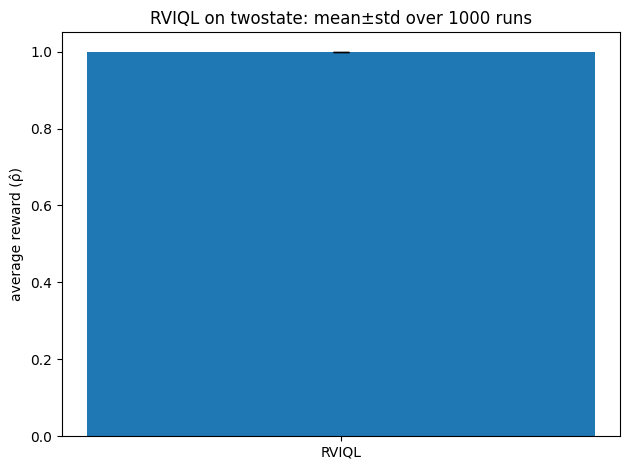

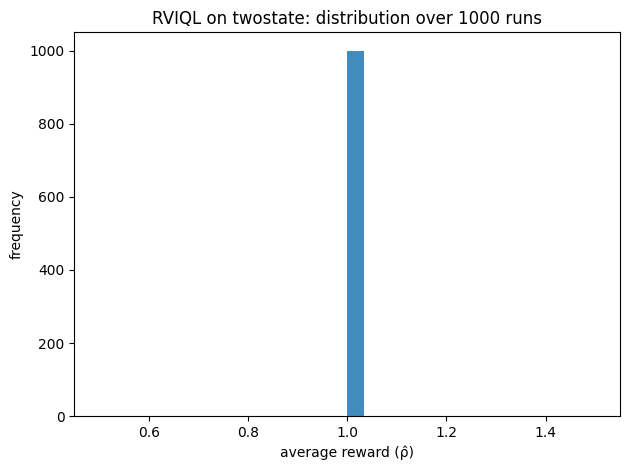

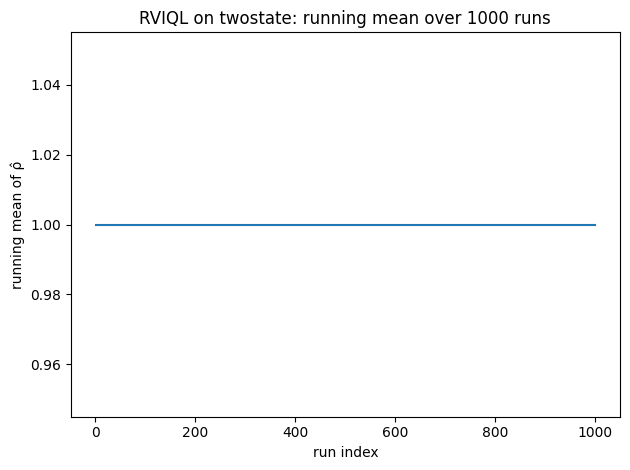

In [41]:
# ==== config ====
TRA_PATH = "/Users/cancetinsoy/mdptest/twostate.tra"
REW_PATH = "/Users/cancetinsoy/mdptest/twostate.tra.rew"
LAB_PATH = "/Users/cancetinsoy/mdptest/twostate.lab"

NUM_RUNS = 1000
NUM_STEPS_PER_RUN = 50_000
BURNIN_STEPS = 5_000

ALPHA = 0.1
EPSILON = 0.1
ANCHOR_EVERY = 512

# optionally pin a reference pair for reproducibility across mdps
REF_STATE = None     # e.g., 0
REF_ACTION = None    # e.g., 0

# ==== imports ====
import os, csv, random, collections
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from explicit2py_converter import ExplicitMDPEnv

MDP_NAME = Path(TRA_PATH).stem
SAVE_CSV  = f"rviql_results_{MDP_NAME}.csv"
PLOT_BAR  = f"rviql_bar_mean_std_{MDP_NAME}.png"
PLOT_HIST = f"rviql_hist_rho_{MDP_NAME}.png"
PLOT_LINE = f"rviql_running_mean_{MDP_NAME}.png"

# ==== env factory ====
def make_env(seed):
    return ExplicitMDPEnv(
        tra_path=TRA_PATH,
        rew_path=REW_PATH,
        lab_path=LAB_PATH,
        seed=seed,
    )

# ==== helpers (env returns (state_id,) -> keep ints) ====
def _sid(s):
    return s[0] if isinstance(s, tuple) and len(s) == 1 else int(s)

def greedy_action(env, Q, s):
    acts = env.get_actions(s)
    return max(acts, key=lambda a: Q[(s,a)]) if acts else None

def estimate_rho_empirical(env, Q, steps=20_000, burnin=2_000, seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    s = _sid(env.reset())
    total = 0.0; n = 0
    for t in range(steps):
        a = greedy_action(env, Q, s)
        if a is None:
            s = _sid(env.reset()); continue
        s_next_t, r, done, info = env.step(a)
        s = _sid(s_next_t)
        if t >= burnin:
            total += float(r); n += 1
    return total / max(n, 1)

# ==== rvi q-learning (converter-friendly) ====
def rvi_q_learning_minimal(
    env,
    num_steps=50_000,
    alpha=0.1,
    epsilon=0.1,
    reference_state=None,
    reference_action=None,
    anchor_every=512,
):
    Q = collections.defaultdict(float)

    if reference_state is None or reference_action is None:
        states = sorted(env.get_all_states())
        s_ref = states[0]
        acts_ref = env.get_actions(s_ref)
        if not acts_ref:
            raise ValueError(f"no actions in reference state {s_ref}")
        a_ref = acts_ref[0]
    else:
        s_ref = int(reference_state)
        a_ref = int(reference_action)

    s = _sid(env.reset())

    for t in range(num_steps):
        acts = env.get_actions(s)
        if not acts:
            s = _sid(env.reset()); continue

        a = random.choice(acts) if random.random() < epsilon else max(acts, key=lambda x: Q[(s,x)])

        s_next_t, r, done, info = env.step(a)
        s_next = _sid(s_next_t)
        next_acts = env.get_actions(s_next)
        max_q_next = max((Q[(s_next, ap)] for ap in next_acts), default=0.0)

        baseline = Q[(s_ref, a_ref)]
        delta = float(r) - baseline + max_q_next - Q[(s, a)]
        Q[(s, a)] += alpha * delta

        if (t & (anchor_every - 1)) == 0:
            off = Q[(s_ref, a_ref)]
            if off != 0.0:
                for k in list(Q.keys()):
                    Q[k] -= off

        s = s_next

    off = Q[(s_ref, a_ref)]
    if off != 0.0:
        for k in list(Q.keys()):
            Q[k] -= off

    return Q

# ==== single-run wrapper ====
def run_rvi_once(seed):
    env = make_env(seed)
    Q = rvi_q_learning_minimal(
        env,
        num_steps=NUM_STEPS_PER_RUN,
        alpha=ALPHA,
        epsilon=EPSILON,
        reference_state=REF_STATE,
        reference_action=REF_ACTION,
        anchor_every=ANCHOR_EVERY,
    )
    rho_hat = estimate_rho_empirical(env, Q, steps=NUM_STEPS_PER_RUN, burnin=BURNIN_STEPS, seed=seed)
    return rho_hat

# ==== 1000 runs ====
rhos_rvi = []
for k in range(NUM_RUNS):
    rhos_rvi.append(run_rvi_once(k))

# ==== save csv ====
with open(SAVE_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["algo","mdp","run","rho_hat"])
    for i, v in enumerate(rhos_rvi):
        w.writerow(["RVIQL", MDP_NAME, i, v])

print(f"rviql done on {MDP_NAME}. wrote {SAVE_CSV}")
print(f"[{MDP_NAME}] RVI mean={np.mean(rhos_rvi):.6f}, std={np.std(rhos_rvi):.6f}, min={np.min(rhos_rvi):.6f}, max={np.max(rhos_rvi):.6f}")

# ==== plots ====
# 1) mean ± std bar
plt.figure()
plt.bar([0], [np.mean(rhos_rvi)], yerr=[np.std(rhos_rvi)], capsize=6)
plt.xticks([0], ["RVIQL"])
plt.ylabel("average reward (ρ̂)")
plt.title(f"RVIQL on {MDP_NAME}: mean±std over {NUM_RUNS} runs")
plt.tight_layout()
plt.savefig(PLOT_BAR, dpi=200)
plt.show()

# 2) histogram
plt.figure()
plt.hist(rhos_rvi, bins=30, alpha=0.85)
plt.xlabel("average reward (ρ̂)")
plt.ylabel("frequency")
plt.title(f"RVIQL on {MDP_NAME}: distribution over {NUM_RUNS} runs")
plt.tight_layout()
plt.savefig(PLOT_HIST, dpi=200)
plt.show()

# 3) running mean line plot
plt.figure()
vals = np.array(rhos_rvi)
running_mean = np.cumsum(vals) / np.arange(1, len(vals)+1)
plt.plot(np.arange(1, len(vals)+1), running_mean)
plt.xlabel("run index")
plt.ylabel("running mean of ρ̂")
plt.title(f"RVIQL on {MDP_NAME}: running mean over {NUM_RUNS} runs")
plt.tight_layout()
plt.savefig(PLOT_LINE, dpi=200)
plt.show()